# Group members
- Bui Huy Giap - 23127289
- Le Minh Duc - 23127351
- Vu Tien Dung - 23127354
- Dinh Xuan Khuong - 23127398
- Nguyen Dong Thanh - 23127538

# 0. Import our libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression


# 1. Import data


Data source: https://www.kaggle.com/datasets/rahulvyasm/medical-insurance-cost-prediction

In [2]:
# code here
data_path = "data/medical_insurance.csv"
try:
    df = pd.read_csv(data_path)
    display(df.head())
except FileNotFoundError:
    print("Error: File not found")
except Exception as e:
    print(f"An error occurred: {e}")

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 2. Helper Functions


In [3]:
def hist_plot(feature, title: str, color: str, x_label: str = None, y_label : str = None):
    # Histograms for numerical variables
    # plt.figure(figsize=(4,5))
    plt.hist(feature, color=color, edgecolor= 'black')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

def bar_plot(feature, title: str, color: str):
    # Bar plots for categorical variables
    # plt.figure(figsize=(4,5))
    feature.value_counts().plot(kind = 'bar', color=color)
    plt.title(title)
    plt.show()

def compare_output(y_pred, y_true):
    plt.figure()
    plt.plot(y_pred, c='orange')
    plt.plot(y_true, c='blue')
    plt.xlabel("Index")
    plt.ylabel("Charges")
    plt.legend()
    plt.show()



# 3. Exploratory Data Analysis (EDA)
- How many rows and how many columns?  
- What is the meaning of each row?  
- Are there **<span style="color:red">duplicated rows</span>**?  
- What is the meaning of each column?  
- What is the current data type of each column? Are there columns having **<span style="color:red">inappropriate data types</span>**?  
- With each numerical column, how are values distributed?  
  - What is the percentage of **<span style="color:red">missing values</span>**?  
  - Min? max? Are they **<span style="color:red">abnormal</span>**?  
- With each categorical column, how are values distributed?  
  - What is the percentage of **<span style="color:red">missing values</span>**?  
  - How many different values? Show a few  
  - Are they **<span style="color:red">abnormal</span>**?

In [4]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


There are 2772 rows and 7 columns in total.

In [6]:
df.describe()

,age,bmi,children,charges
count,2772.000000,2772.000000,2772.000000,2772.000000
mean,39.109668,30.701349,1.101732,13261.369959
std,14.081459,6.129449,1.214806,12151.768945
min,18.000000,15.960000,0.000000,1121.873900
25%,26.000000,26.220000,0.000000,4687.797000
50%,39.000000,30.447500,1.000000,9333.014350
75%,51.000000,34.770000,2.000000,16577.779500
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
list(set(df['region']))

['southwest', 'northeast', 'northwest', 'southeast']

In [8]:
list(set(df['smoker']))

['yes', 'no']

In [9]:
list(set(df['sex']))

['male', 'female']

### Meaning of each column

| Column       | Meaning                                                                                                                                 |
| ------------ | --------------------------------------------------------------------------------------------------------------------------------------- |
| **age**      | Age of the individual (in years).                                 |
| **sex**      | Gender of the individual (male or female). |
| **bmi**      | Body Mass Index of the individual (a measure of body fat based on height/weight).                         |
| **children** | Number of children/dependents the individual has.                                                                  |
| **smoker**   | Whether the individual is a smoker (“yes” if they smoke, “no” if they don’t).                                     |
| **region**   | The geographic region where the individual lives (e.g., northeast, northwest, southeast, southwest in the US context).  |
| **charges**  | The medical insurance cost or charges for the individual (target variable in the dataset).                   |



## Duplicate checking

In [10]:
df.duplicated().sum()

1435

In [11]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [12]:
dups = df[df.duplicated(keep=False)]
dups


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


Some columns that are duplicated

In [13]:
dups.groupby(df.columns.tolist()).size()

age  sex     bmi     children  smoker  region     charges    
18   female  20.790  0         no      southeast  1607.51010     2
             21.660  0         yes     northeast  14283.45940    2
             24.090  1         no      southeast  2201.09710     2
             25.080  0         no      northeast  2196.47320     2
             26.315  0         no      northeast  2198.18985     2
                                                                ..
64   male    36.960  2         yes     southeast  49577.66240    4
             37.905  0         no      northwest  14210.53595    2
             38.190  0         no      northeast  14410.93210    2
             39.160  1         no      southeast  14418.28040    2
             40.480  0         no      southeast  13831.11520    2
Length: 1337, dtype: int64

In [14]:
df = df.drop_duplicates().reset_index(drop=True)
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1332,50,male,30.970,3,no,northwest,10600.54830
1333,18,female,31.920,0,no,northeast,2205.98080
1334,18,female,36.850,0,no,southeast,1629.83350
1335,21,female,25.800,0,no,southwest,2007.94500


## Distribution of each feature

In [15]:
categorical_names = ["sex", "children", "smoker", "region"]
regression_names = [name for name in df.columns.to_list() if name not in  categorical_names]
regression_names, categorical_names


(['age', 'bmi', 'charges'], ['sex', 'children', 'smoker', 'region'])

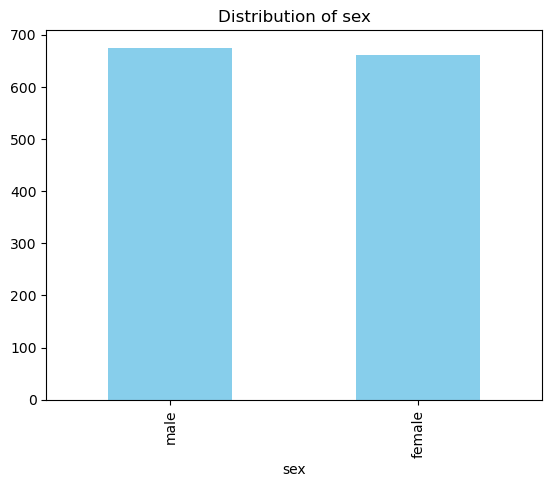

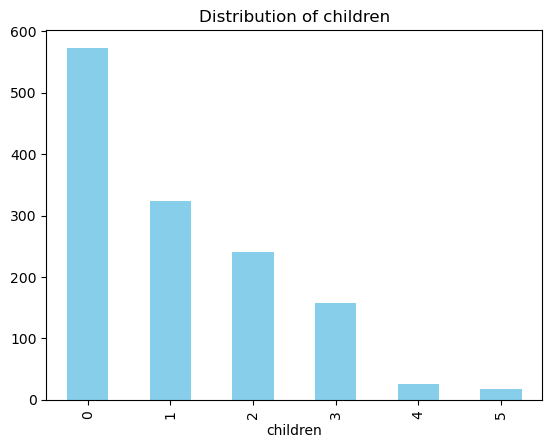

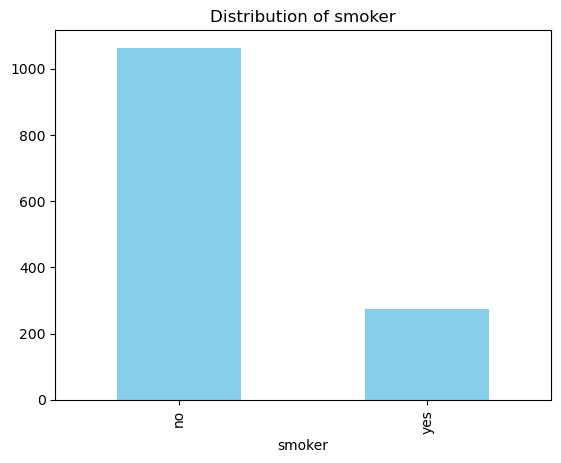

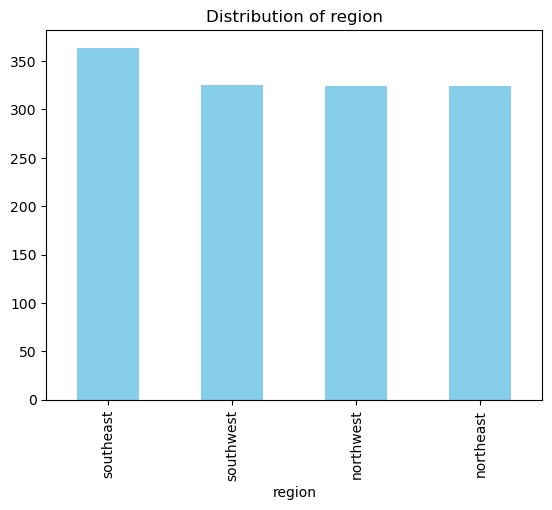

In [16]:
for name in categorical_names:
    bar_plot(df[name], f"Distribution of {name}", "skyblue")

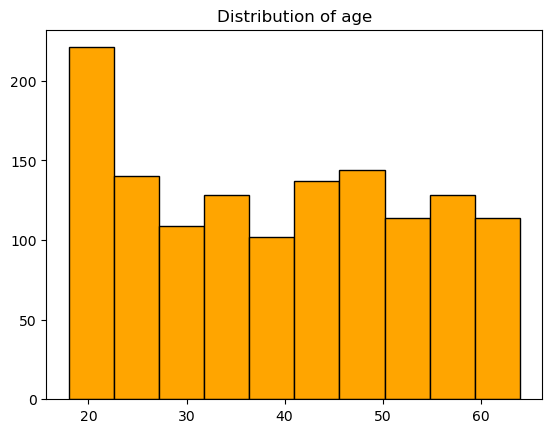

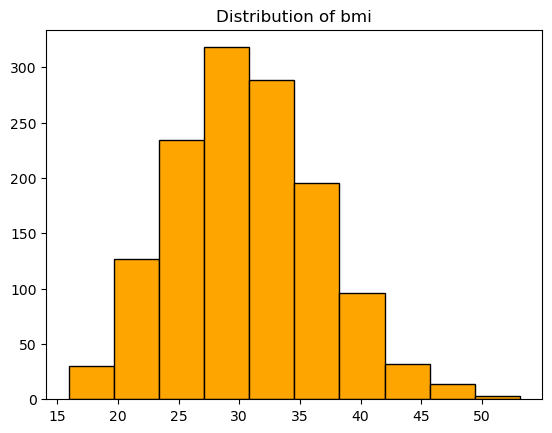

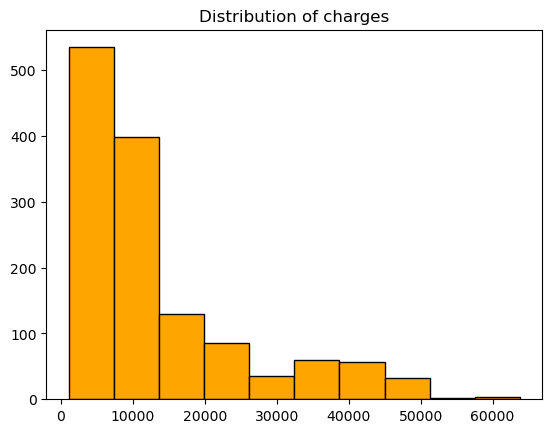

In [17]:
for name in regression_names:
    hist_plot(df[name], f"Distribution of {name}", "orange")

In [18]:
def encode_categorical(data):
    data = data.copy()
    # Perform one-hot encoding
    one_hot_sex = pd.get_dummies(data['sex'], dtype=int, drop_first=True)
    one_hot_smoker = pd.get_dummies(data['smoker'], dtype=int, drop_first=True)
    one_hot_region = pd.get_dummies(data['region'], dtype=int, drop_first=False)

    # Concatenate the one-hot encoded columns with the original DataFrame
    df_encoded = pd.concat([data.iloc[:, :-1], one_hot_region, data.iloc[:, -1]], axis=1)
    df_encoded.drop(columns=['region'], inplace=True)
    df_encoded['sex'] = one_hot_sex
    df_encoded['smoker'] = one_hot_smoker

    return df_encoded

In [19]:
df = encode_categorical(df)
df

,age,sex,bmi,children,smoker,northeast,northwest,southeast,southwest,charges
0,19,0,27.900,0,1,0,0,0,1,16884.92400
1,18,1,33.770,1,0,0,0,1,0,1725.55230
2,28,1,33.000,3,0,0,0,1,0,4449.46200
3,33,1,22.705,0,0,0,1,0,0,21984.47061
4,32,1,28.880,0,0,0,1,0,0,3866.85520
...,...,...,...,...,...,...,...,...,...,...
1332,50,1,30.970,3,0,0,1,0,0,10600.54830
1333,18,0,31.920,0,0,1,0,0,0,2205.98080
1334,18,0,36.850,0,0,0,0,1,0,1629.83350
1335,21,0,25.800,0,0,0,0,0,1,2007.94500


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1337 non-null   int64  
 1   sex        1337 non-null   int64  
 2   bmi        1337 non-null   float64
 3   children   1337 non-null   int64  
 4   smoker     1337 non-null   int64  
 5   northeast  1337 non-null   int64  
 6   northwest  1337 non-null   int64  
 7   southeast  1337 non-null   int64  
 8   southwest  1337 non-null   int64  
 9   charges    1337 non-null   float64
dtypes: float64(2), int64(8)
memory usage: 104.6 KB


In [21]:
df.isnull().sum()

age          0
sex          0
bmi          0
children     0
smoker       0
northeast    0
northwest    0
southeast    0
southwest    0
charges      0
dtype: int64

We can see that there is no null value in our dataframe

## Relationship Checking

In [22]:
def scatter_mean(df, x_name: str, y_name: str):
    sns.scatterplot(x = x_name, y = y_name, data=df, alpha=0.6)

    mean_df = df.groupby(x_name, as_index=False)[y_name].mean()

    sns.lineplot(x = x_name, y = y_name, data=mean_df, color="red", linewidth=2)

    plt.title(f"Scatter plot of {x_name} and {y_name} with mean line")
    plt.show()

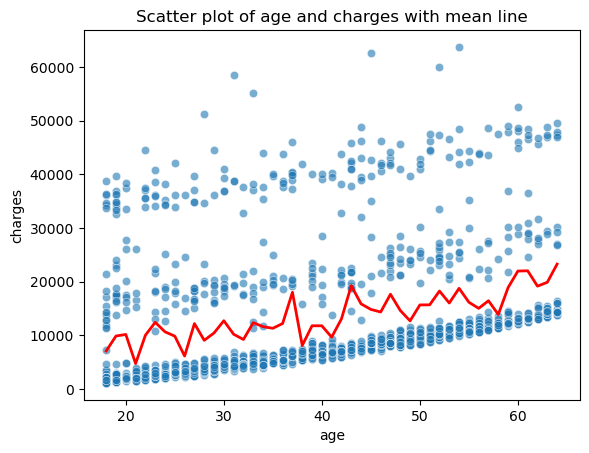

In [23]:
scatter_mean(df, "age", "charges")

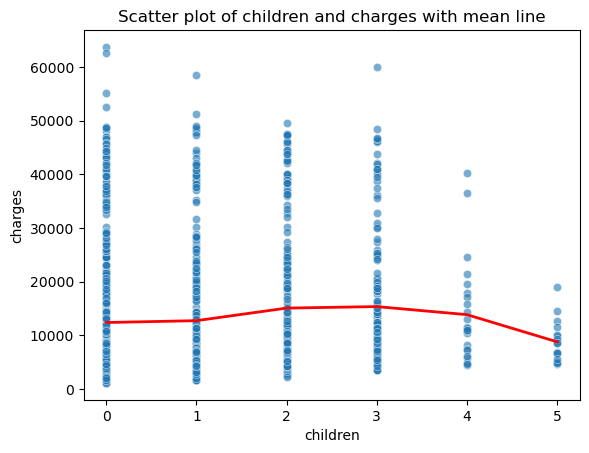

In [24]:
scatter_mean(df, "children", "charges")

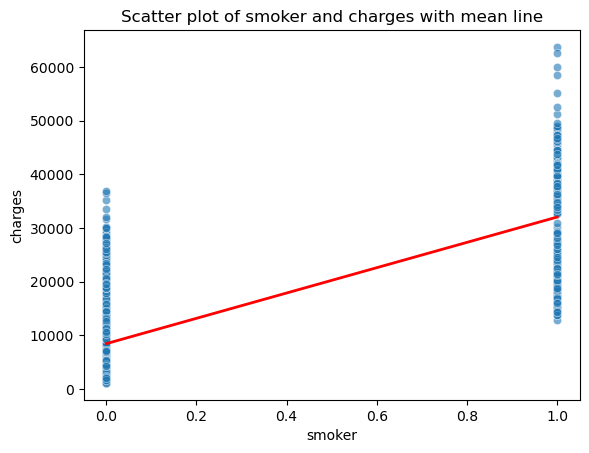

In [25]:
scatter_mean(df, "smoker", "charges")

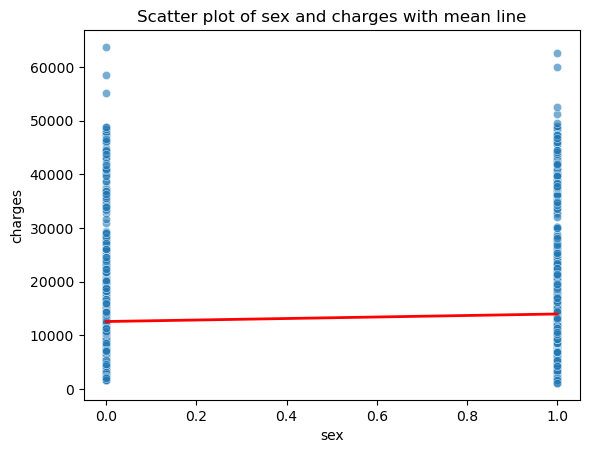

In [26]:
scatter_mean(df, "sex", "charges")

In [27]:
column_names = df.columns.to_list()
column_names

['age',
 'sex',
 'bmi',
 'children',
 'smoker',
 'northeast',
 'northwest',
 'southeast',
 'southwest',
 'charges']

In [28]:
def scatter_mean_regression(df, x_name, y_name, bins=10):
    df_copy = df.copy()

    df_copy["x_bin"] = pd.cut(df_copy[x_name], bins=bins)

    mean_df = df_copy.groupby("x_bin", observed=True, as_index=False)[y_name].mean()

    mean_df["x_center"] = mean_df["x_bin"].apply(lambda x: x.mid)

    sns.scatterplot(x=x_name, y=y_name, data=df_copy, alpha=0.4)
    sns.lineplot(x="x_center", y=y_name, data=mean_df, color="red", linewidth=2, marker="o")

    plt.title(f"Scatter plot of {x_name} and {y_name} with mean line")
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.show()


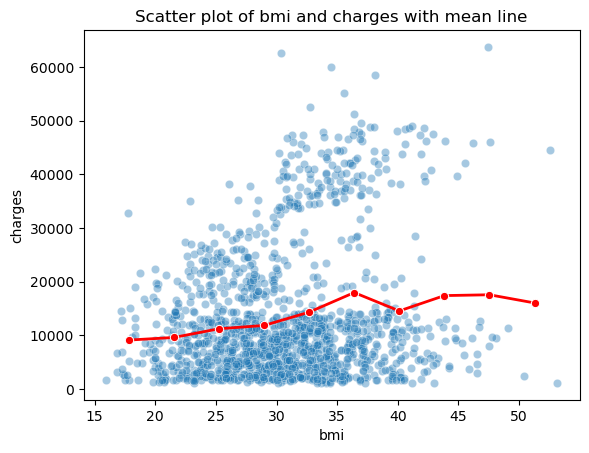

In [29]:
scatter_mean_regression(df, "bmi", "charges")

# 4. Building models


# 5. Evaluate 

# 6. Reflection
- **Each member:** What difficulties have you encountered?  
- **Each member:** What have you learned?  
- **Your group:** If you had more time, what would you do?


# 7. References
- To finish this project, what materials have you consulted